In [1]:
library(dplyr)
library(purrr)
library(tidyr)
library(ggplot2)
library(forecast)
library(lubridate)
library(moments)
library(psych)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘purrr’

The following object is masked from ‘package:dplyr’:

    order_by

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘moments’

The following objects are masked from ‘package:timeDate’:

    kurtosis, skewness


Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



In [2]:
load('data_ps_days.dat')

In [3]:
print("Press metadata")
data_ps_days %>% select(-data) %>% str()

[1] "Press metadata"
Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	851 obs. of  17 variables:
 $ event_press                 : Factor w/ 851 levels "40000024","40000028",..: 842 597 549 587 610 371 373 435 13 14 ...
 $ Product_Line                : Factor w/ 3 levels "HP Indigo 7000",..: 3 3 3 3 3 2 2 2 1 1 ...
 $ event_name                  : Factor w/ 1 level "SAMPLE_PIP_AND_IMO_PARAMETERS": 1 1 1 1 1 1 1 1 1 1 ...
 $ series                      : Factor w/ 1 level "7000 Family Sheet Fed Commercial Press": 1 1 1 1 1 1 1 1 1 1 ...
 $ Region                      : Factor w/ 2 levels "Europe, Middle East & Africa",..: 2 2 2 2 2 2 1 1 2 2 ...
 $ SubRegion                   : Factor w/ 15 levels "Benelux","Canada",..: 9 2 12 11 12 3 1 1 15 12 ...
 $ District                    : Factor w/ 12 levels "BELGIUM","Canada",..: 12 12 12 12 12 12 9 9 12 12 ...
 $ Ownership                   : Factor w/ 1 level "DIRECT": 1 1 1 1 1 1 1 1 1 1 ...
 $ scale_factor_PIP_Temperature: num  100 100 100 100 100

**Data Dictionary**

* scale_factor_FEATURE - factor by which to multiply to turn a scaled_FEATURE to the original value.
* events - number of total events for the press
* number of days from the first instance to the last instance

In [4]:
print("Press Data")
(data_ps_days %>% select(data))[[1]][[1]] %>% str()

[1] "Press Data"
'data.frame':	178 obs. of  122 variables:
 $ time_slice                          : POSIXct, format: "2016-01-05" "2016-01-06" ...
 $ PIP_Temperature_mean                : num  289 NA 263 276 NA ...
 $ IO_temperature_mean                 : num  244 NA 246 243 NA ...
 $ IO_dirtiness_mean                   : num  825 NA 825 825 NA NA 825 825 NA 825 ...
 $ CS_Voltage_mean                     : num  1846 NA 1846 1846 NA ...
 $ vessel_flow_mean                    : num  4233 NA 4248 4368 NA ...
 $ scaled_PIP_Temperature_mean         : num  2.89 NA 2.63 2.76 NA ...
 $ scaled_IO_temperature_mean          : num  2.44 NA 2.46 2.43 NA ...
 $ scaled_IO_dirtiness_mean            : num  8.25 NA 8.25 8.25 NA NA 8.25 8.25 NA 8.25 ...
 $ scaled_CS_Voltage_mean              : num  1.85 NA 1.85 1.85 NA ...
 $ scaled_vessel_flow_mean             : num  4.23 NA 4.25 4.37 NA ...
 $ PIP_Temperature_median              : num  292 NA 263 276 NA NA 265 291 NA 284 ...
 $ IO_temperature_median   

**Data Dictionary**

* interp - means the values have been interpolated to add data where the press didn't have values for that day, after computing the aggregation function.

* event_slice_count - number of actual events for the press on that particular day. A 0 would mean no events found to aggregate.

* scaled - means the values have been scaled using the scaled factor before the aggregation

* FEATURE_FUN - FUN is the aggregation used. One of "mean, median, sd, IQR, max, min, amplitude".

,PIP_Temperature_mean,IO_temperature_mean,vessel_flow_mean,CS_Voltage_mean
vars,1,2,3,4
n,44256,44256,39744,44256
mean,294.0217,263.8070,4009.7191,2089.8304
sd,22.15001,36.41798,720.87473,265.36761
min,-102.5,0.0,0.0,0.0
max,424.5,500.0,13854.0,2900.0
range,527,500,13854,2900
se,0.1052902,0.1731130,3.6159633,1.2614262


Warning message:
: Removed 87921 rows containing non-finite values (stat_bin).Warning message:
: Removed 87921 rows containing non-finite values (stat_bin).Warning message:
: Removed 92433 rows containing non-finite values (stat_bin).Warning message:
: Removed 87921 rows containing non-finite values (stat_bin).

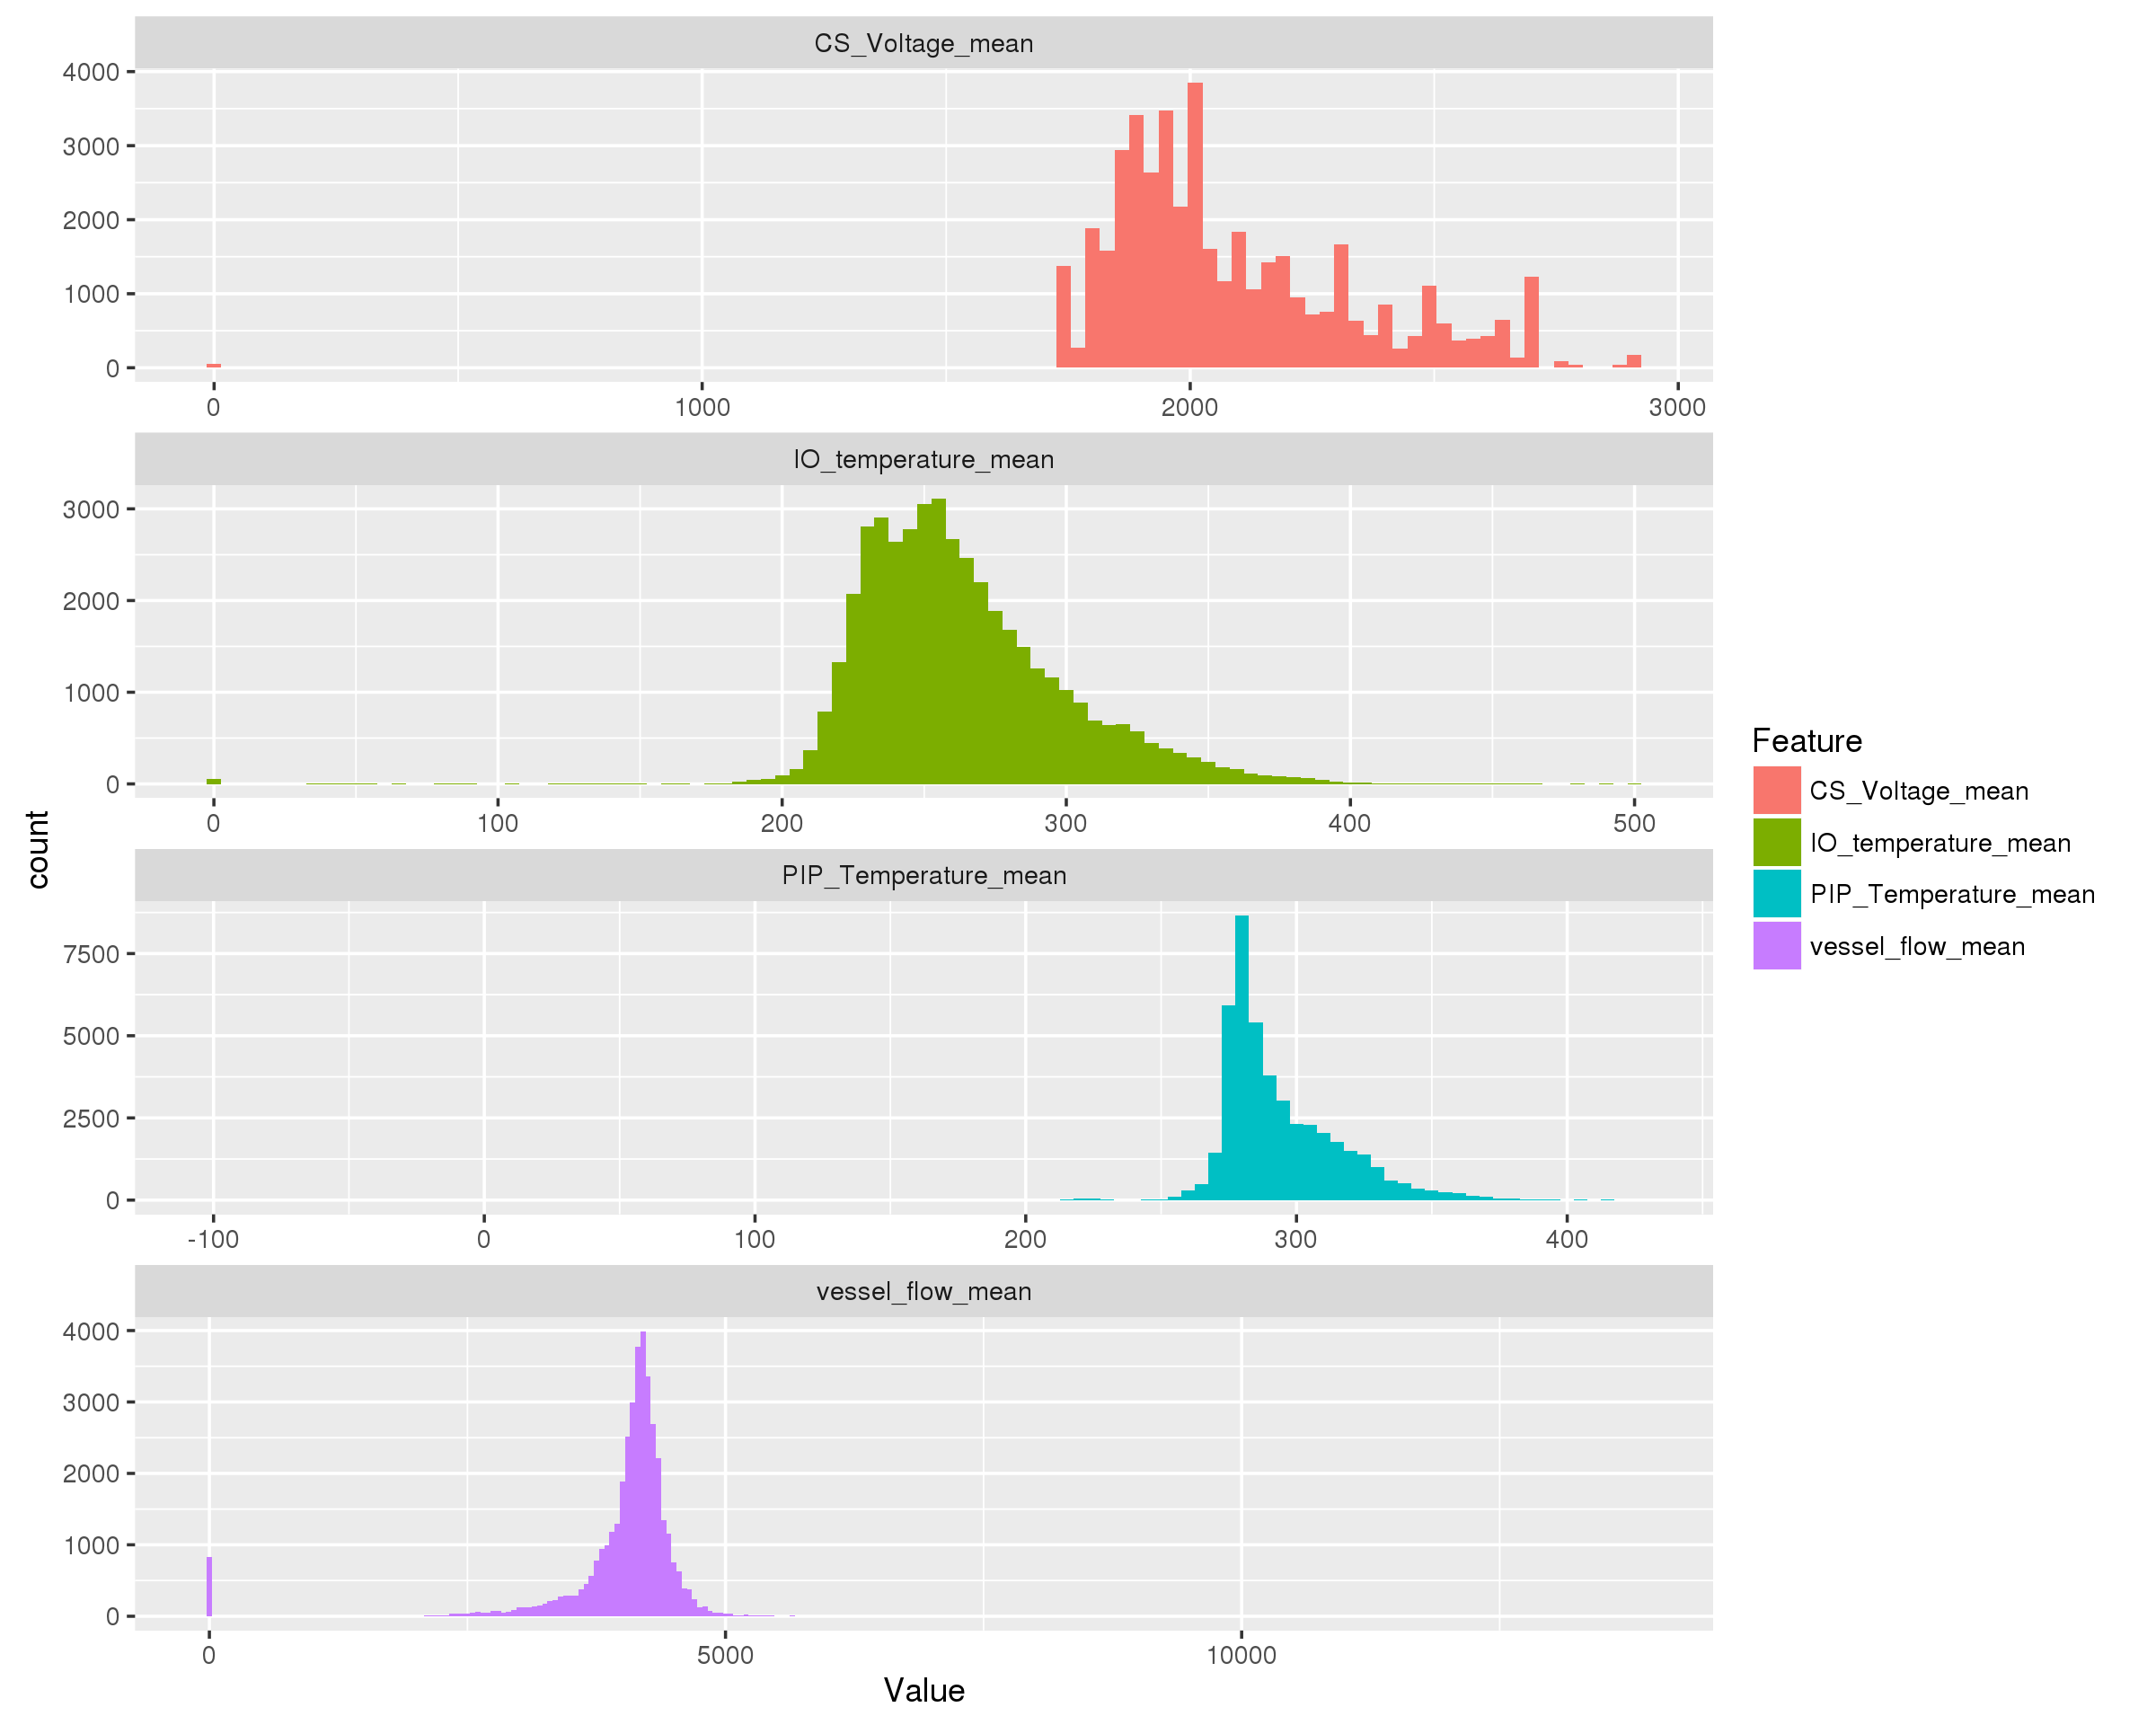

In [5]:
#Mean data distribution

options(repr.plot.width=10, repr.plot.height = 8, repr.plot.res = 240)

hist_data <- data_ps_days %>% unnest() %>%
  select(PIP_Temperature_mean, IO_temperature_mean, vessel_flow_mean, CS_Voltage_mean) 

hist_data %>% describe(skew = F) %>% t()

hist_data <- hist_data %>%
  gather(key = Feature, value = Value)

hist_data %>%
  ggplot(aes(x = Value, fill = Feature)) +
  geom_histogram(data = hist_data %>% filter(Feature == "PIP_Temperature_mean"), binwidth = 5) +
  geom_histogram(data = hist_data %>% filter(Feature == "IO_temperature_mean"), binwidth = 5) +
  geom_histogram(data = hist_data %>% filter(Feature == "vessel_flow_mean"), binwidth = 50) +
  geom_histogram(data = hist_data %>% filter(Feature == "CS_Voltage_mean"), binwidth = 30) +
  facet_wrap( ~ Feature, scales = "free", nrow = 4)

rm(hist_data)

## Cleaning out Data Frame

* Filtering out data that failed have values interpolated: This will remove printers with very few or sparce values. 

In [6]:
data_ps_days_filtered <- data_ps_days %>% mutate(complete = sapply(data, function(x){
  if(nrow(x) == 0) {
    return(FALSE)
  }
  s <- select(x, starts_with("interp"));
  return(nrow(s) == nrow(na.omit(s)))
  }
)) %>% filter(complete == TRUE)


* Separating dataset into training and test: Training will be the date from Jan 1st 2016 to April 30th 2016.
* We will remove printers that after filter have less than 30 days worth of events remaining so that when we apply the 21 days sliding window there are some events to be analysed.

In [7]:
data_ps_days_train <- data_ps_days_filtered %>%
  mutate( data = data %>% map(function(df) { filter(df, time_slice < as.POSIXct("2016-05-01", tz="UTC")) })) %>%
  mutate( days = data %>% map_int(nrow),
          events = data %>% map_dbl(function(df) { sum(df$event_slice_count)})) %>%
  filter( days > 30 )

data_ps_days_test <- data_ps_days_filtered %>%
  mutate( data = data %>% map(function(df) { filter(df, time_slice >= as.POSIXct("2016-05-01", tz="UTC")) })) %>%
  mutate( days = data %>% map_int(nrow),
          events = data %>% map_dbl(function(df) { sum(df$event_slice_count)})) %>%
  filter( days > 30 )

In [16]:
cat("Training data\n")
data_ps_days_train %>% select(Product_Line, Region, SubRegion, District, events, days) %>% summary()
cat("Test data\n")
data_ps_days_test %>% select(Product_Line, Region, SubRegion, District, events, days) %>% summary()

Training data


         Product_Line                          Region   
 HP Indigo 7000:175   Europe, Middle East & Africa:266  
 HP Indigo 7500:205   North America               :450  
 HP Indigo 7600:336                                     
                                                        
                                                        
                                                        
                                                        
                     SubRegion             District       events      
 MidAtlantic United States: 75   UNITED STATES :412   Min.   :   1.0  
 Southern United States   : 72   UNITED KINGDOM: 67   1st Qu.:  37.0  
 UK & Ireland             : 70   GERMANY       : 56   Median :  94.0  
 Central United States    : 67   NETHERLANDS   : 46   Mean   : 172.1  
 Southwest United States  : 58   Canada        : 38   3rd Qu.: 220.2  
 Germany                  : 56   FRANCE        : 35   Max.   :2619.0  
 (Other)                  :318   (Other)       

Test data


         Product_Line                          Region   
 HP Indigo 7000:159   Europe, Middle East & Africa:252  
 HP Indigo 7500:190   North America               :416  
 HP Indigo 7600:319                                     
                                                        
                                                        
                                                        
                                                        
                     SubRegion             District       events       
 UK & Ireland             : 69   UNITED STATES :380   Min.   :   1.00  
 MidAtlantic United States: 68   UNITED KINGDOM: 66   1st Qu.:  22.00  
 Central United States    : 64   GERMANY       : 50   Median :  51.50  
 Southern United States   : 63   NETHERLANDS   : 45   Mean   :  99.81  
 Southwest United States  : 53   Canada        : 36   3rd Qu.: 123.00  
 Benelux                  : 52   FRANCE        : 30   Max.   :2179.00  
 (Other)                  :299   (Other)

* calculating multiple windows as new features:
    - The mean of the last 7 days (mean, median, sd, IQR, min and max)
    - The mean of the last 14 days (mean, median, sd, IQR, min and max)
    - The mean of the last 21 days (mean, median, sd, IQR, min and max)
  
 The calculation will be done for the original feature values as well as the scaled values and the interpolated values creating columns with the following prefix:
 
 width\_WINDOW\_mean\_ : where WINDOW is how much in the past we look to calculate the mean.

In [15]:
features <- c("PIP_Temperature", "IO_temperature", "IO_dirtiness", "CS_Voltage", "vessel_flow")
scaled_features <- map_chr(features, function(x){ paste0("scaled_",x) })
interp_features <- map_chr(features, function(x){ paste0("interp_",x) })
interp_scaled_features <- map_chr(features, function(x){ paste0("interp_scaled_",x) })

apply_window <- function(df, width = 7, features){
  all_features <- df[, grepl(paste0(map_chr(features, function(x){ paste0("^",x) }), collapse = "|"), names(df))] %>% names()
  for(feature in all_features) {
    tryCatch({
      df[[paste0("width_", width, "_mean_", feature)]] <- rollmean(df[[feature]],
                                                                   k = width, na.rm = T,
                                                                   fill = c(NA, NULL, NA),
                                                                   align = "right")

    }, error = function(err){
      warning(err, call = TRUE)
    })
  }
  df
}


data_ps_days_train <- data_ps_days_train %>%
  mutate(data = data %>% map(apply_window, width = 7, features)) %>%
  mutate(data = data %>% map(apply_window, width = 14, features)) %>%
  mutate(data = data %>% map(apply_window, width = 21, scaled_features))%>%
  mutate(data = data %>% map(apply_window, width = 7, scaled_features)) %>%
  mutate(data = data %>% map(apply_window, width = 14, scaled_features)) %>%
  mutate(data = data %>% map(apply_window, width = 21, scaled_features))%>%
  mutate(data = data %>% map(apply_window, width = 7, interp_features)) %>%
  mutate(data = data %>% map(apply_window, width = 14, interp_features)) %>%
  mutate(data = data %>% map(apply_window, width = 21, interp_features))%>%
  mutate(data = data %>% map(apply_window, width = 7, interp_scaled_features)) %>%
  mutate(data = data %>% map(apply_window, width = 14, interp_scaled_features)) %>%
  mutate(data = data %>% map(apply_window, width = 21, interp_scaled_features))

data_ps_days_test <- data_ps_days_test %>%
  mutate(data = data %>% map(apply_window, width = 7, features)) %>%
  mutate(data = data %>% map(apply_window, width = 14, features)) %>%
  mutate(data = data %>% map(apply_window, width = 21, scaled_features))%>%
  mutate(data = data %>% map(apply_window, width = 7, scaled_features)) %>%
  mutate(data = data %>% map(apply_window, width = 14, scaled_features)) %>%
  mutate(data = data %>% map(apply_window, width = 21, scaled_features))%>%
  mutate(data = data %>% map(apply_window, width = 7, interp_features)) %>%
  mutate(data = data %>% map(apply_window, width = 14, interp_features)) %>%
  mutate(data = data %>% map(apply_window, width = 21, interp_features))%>%
  mutate(data = data %>% map(apply_window, width = 7, interp_scaled_features)) %>%
  mutate(data = data %>% map(apply_window, width = 14, interp_scaled_features)) %>%
  mutate(data = data %>% map(apply_window, width = 21, interp_scaled_features))

In [17]:
data_ps_days_train %>% select(event_press, data) %>% unnest() %>% summary()

   event_press      time_slice                  PIP_Temperature_mean
 40000177:  121   Min.   :2016-01-01 00:00:00   Min.   :-102.5      
 40000243:  121   1st Qu.:2016-02-06 00:00:00   1st Qu.: 279.0      
 40000289:  121   Median :2016-03-05 00:00:00   Median : 287.0      
 43000188:  121   Mean   :2016-03-04 18:34:03   Mean   : 293.7      
 45000257:  121   3rd Qu.:2016-04-02 00:00:00   3rd Qu.: 305.0      
 40000159:  120   Max.   :2016-04-30 00:00:00   Max.   : 424.0      
 (Other) :78724                                 NA's   :52420       
 IO_temperature_mean IO_dirtiness_mean CS_Voltage_mean vessel_flow_mean
 Min.   :  0.0       Min.   :   0.0    Min.   :   0    Min.   :    0   
 1st Qu.:238.3       1st Qu.: 463.1    1st Qu.:1900    1st Qu.: 3954   
 Median :256.0       Median : 828.0    Median :2000    Median : 4152   
 Mean   :263.1       Mean   : 678.9    Mean   :2085    Mean   : 4021   
 3rd Qu.:281.0       3rd Qu.: 994.0    3rd Qu.:2223    3rd Qu.: 4289   
 Max.   :500.0  

In [18]:
data_ps_days_test %>% select(event_press, data) %>% unnest() %>% summary()

   event_press      time_slice                  PIP_Temperature_mean
 40000038:   61   Min.   :2016-05-01 00:00:00   Min.   :-68.0       
 40000062:   61   1st Qu.:2016-05-15 00:00:00   1st Qu.:279.0       
 40000064:   61   Median :2016-05-29 00:00:00   Median :287.2       
 40000070:   61   Mean   :2016-05-29 14:16:40   Mean   :294.4       
 40000075:   61   3rd Qu.:2016-06-13 00:00:00   3rd Qu.:306.7       
 40000089:   61   Max.   :2016-06-30 00:00:00   Max.   :424.5       
 (Other) :37912                                 NA's   :24380       
 IO_temperature_mean IO_dirtiness_mean CS_Voltage_mean vessel_flow_mean
 Min.   :  0.0       Min.   :   0.0    Min.   :   0    Min.   :    0   
 1st Qu.:238.0       1st Qu.: 646.0    1st Qu.:1900    1st Qu.: 3945   
 Median :258.5       Median : 829.0    Median :2000    Median : 4146   
 Mean   :263.2       Mean   : 694.6    Mean   :2083    Mean   : 3991   
 3rd Qu.:280.5       3rd Qu.: 996.0    3rd Qu.:2220    3rd Qu.: 4278   
 Max.   :479.0  